# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import pickle
import math
import random
import warnings
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
from IPython.display import Image
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y):
    
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max ( 0, chi2 - ( k-1 ) * ( r-1 ) / ( n-1 ) )
    kcorr = k - ( k-1 )**2 / ( n-1 )
    rcorr = r - ( r-1 )**2 / ( n-1 )
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )
     
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model_Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse}, index=[0] )



def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    mae_list = []
    mape_list=[]
    rmse_list=[]

    for k  in reversed( range( 1, kfold+1) ):
        if verbose:
            print( f'\nKFold Number: {k}' )

        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days =( k-1 )*6*7 )

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date )]

        #training and validation datasets
        #training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        #model
        m = model.fit( xtraining, ytraining )

        #prediction
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error(model_name, np.expm1( yvalidation ), np.expm1( yhat ) )


        #store performance for each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        #print(  lr_result )


    return pd.DataFrame({
                'Model Name': model_name,
                'MAE CV': [f"{np.round(np.mean(mae_list), 2)} +/- {np.round(np.std(mae_list), 2)}"],
                'MAPE CV': [f"{np.round(np.mean(mape_list), 2)} +/- {np.round(np.std(mape_list), 2)}"],
                'RMSE CV': [f"{np.round(np.mean(rmse_list), 2)} +/- {np.round(np.std(rmse_list), 2)}"]
                   })

## Loading data

In [3]:
df_sales_raw = pd.read_csv('/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
323669,397,1,2014-09-29,7417,892,1,1,0,0,a,c,130.0,NaN,NaN,1,27.0,2013.0,"Feb,May,Aug,Nov"


# 1.0  PASSO 01 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Cols: {df1.shape[1]}")

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply ( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)


#promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval 
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0 , axis = 1)


## 1.6. Chage Types

In [90]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include =['int64', 'float64' ])
cat_attributes = df1.select_dtypes( exclude =['int64', 'float64', 'datetime64[ns]' ])

## 1.7.1 Numerical Attributes

In [18]:
# central tendency - man, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

# dispersion- std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() - x.min() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() - x.min() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.000955,-2.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-0.998407,-2.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,-9.757656,127.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.042076,-2.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-1907.235657,-1775.928696


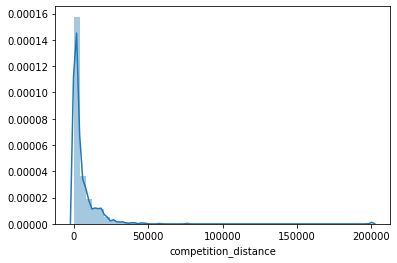

In [20]:
sns.distplot( df1['competition_distance'] )

## 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

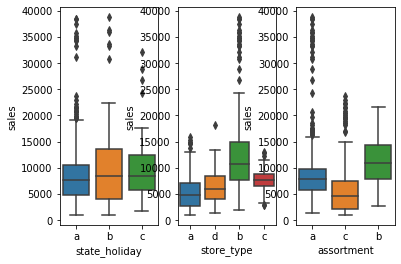

In [22]:
aux1 = df1[( df1['state_holiday'] !='0' ) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

## 2.1. Mapa mental de Hipoteses

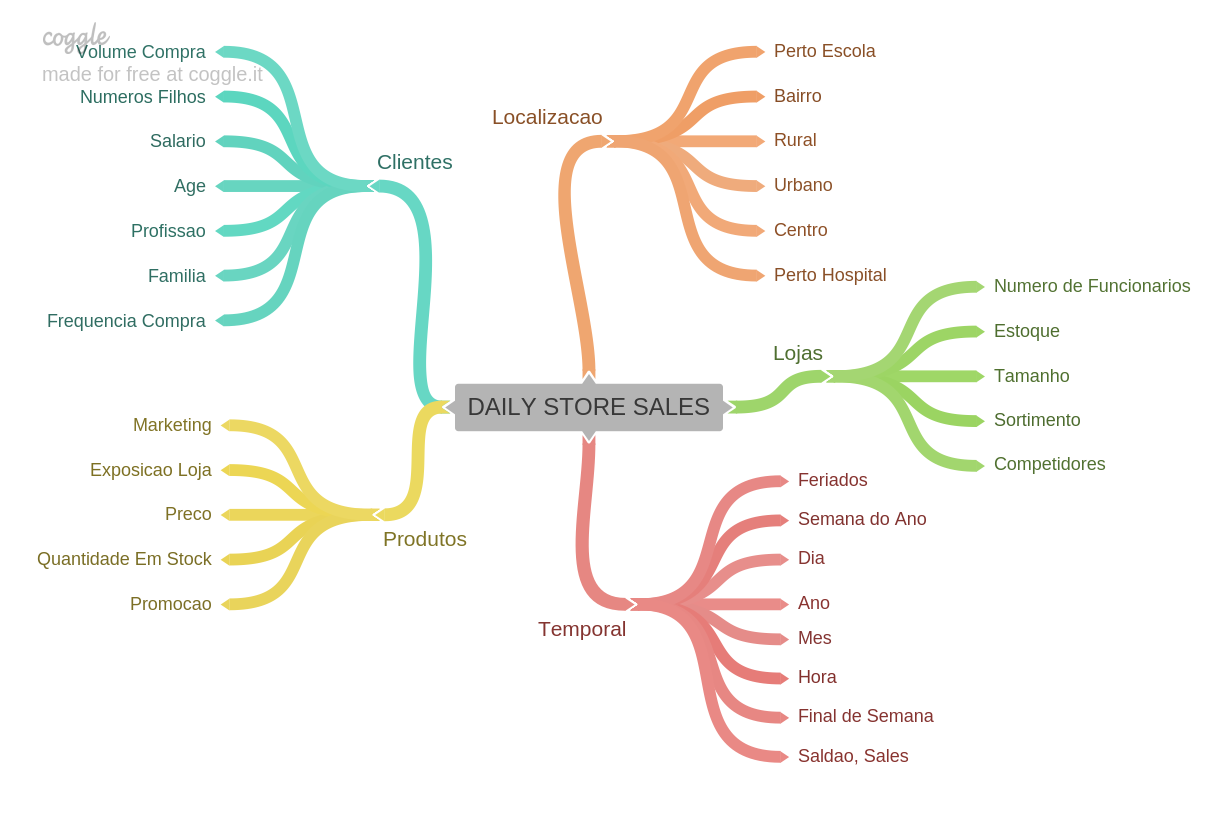

In [24]:
Image( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/img/MindMapHypothesis.png' )

## 2.1. Criação das hipóteses

### 2.1.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior portem deveriam vender mais

**4.** Lojas com menor menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender mais.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipoteses tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender menos.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos fins de semana.

**6.** Lojas deveriam vender menos nos feriados escolares.

## 2.2 Lista final de hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender mais.

**3.** Lojas com competidores à mais tempo deveriam vender mais.



**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**1.** Lojas abertas durante o feriado de Natal deveriam vender menos.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos fins de semana.

**6.** Lojas deveriam vender menos nos feriados escolares.

## 2.3 Feature engineering

In [25]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else  'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

In [28]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas

In [29]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2. Seleção de colunas

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1 )

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [32]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

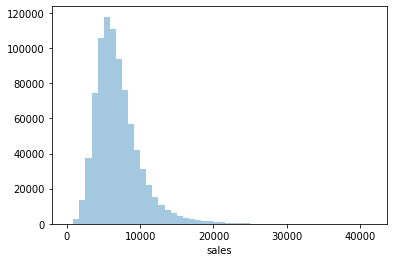

In [33]:
sns.distplot( df4['sales'], kde = False )

### 4.1.2 Numerical Variables

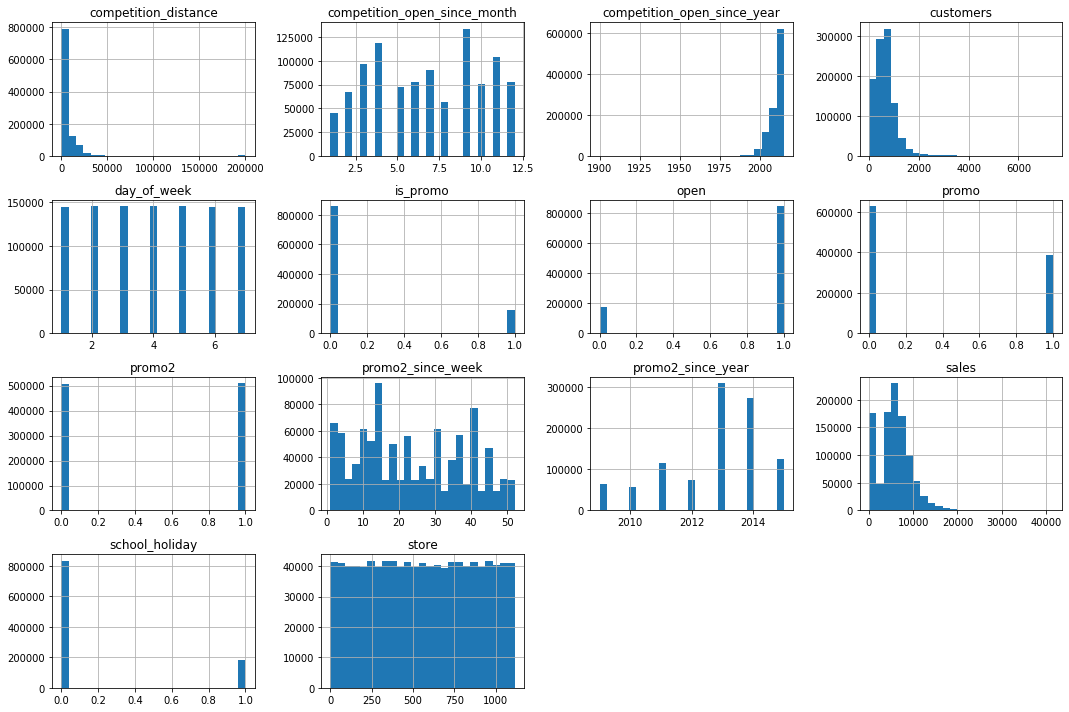

In [34]:
num_attributes.hist(bins=25, figsize=(15, 10), layout=(4, 4))
plt.tight_layout()
plt.show()

### 4.1.2 Categorical Variables

In [35]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

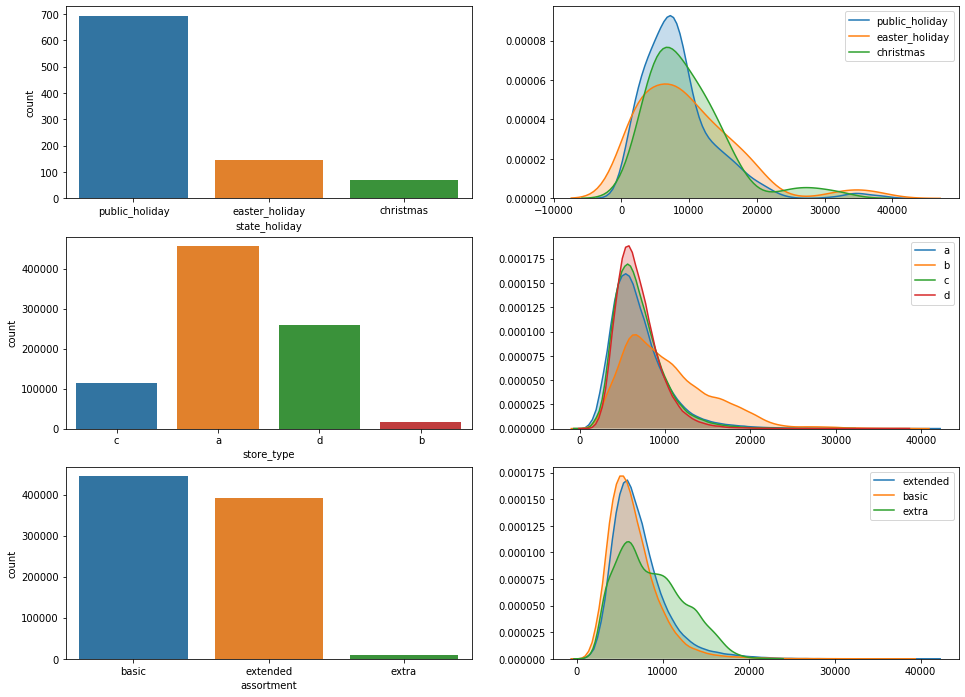

In [36]:

plt.figure(figsize=(16, 12))
#state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],  label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],  label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],  label = 'christmas', shade = True)



#Store_type
plt.subplot( 3, 2, 3 )
sns.countplot(df4['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],  label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],  label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],  label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],  label = 'd', shade = True)


#assortment
plt.subplot( 3, 2, 5 )
sns.countplot(df4['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],  label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],  label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],  label = 'extra', shade = True)


## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.
**Falsa** Lojas com MAIOR SORTIMENTO vendem MENOS.


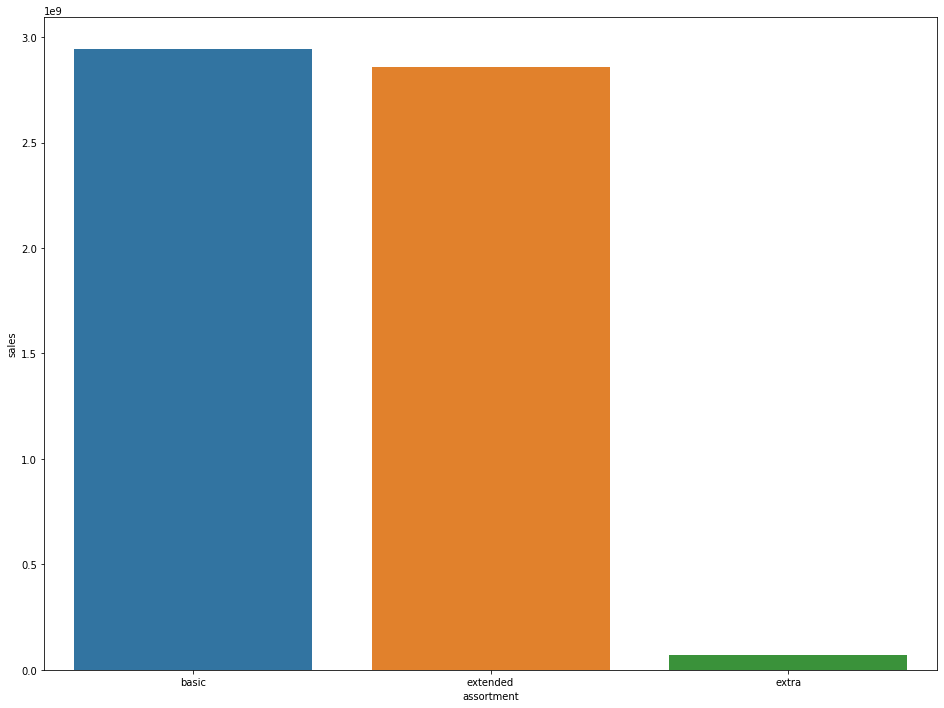

<Figure size 1296x576 with 0 Axes>

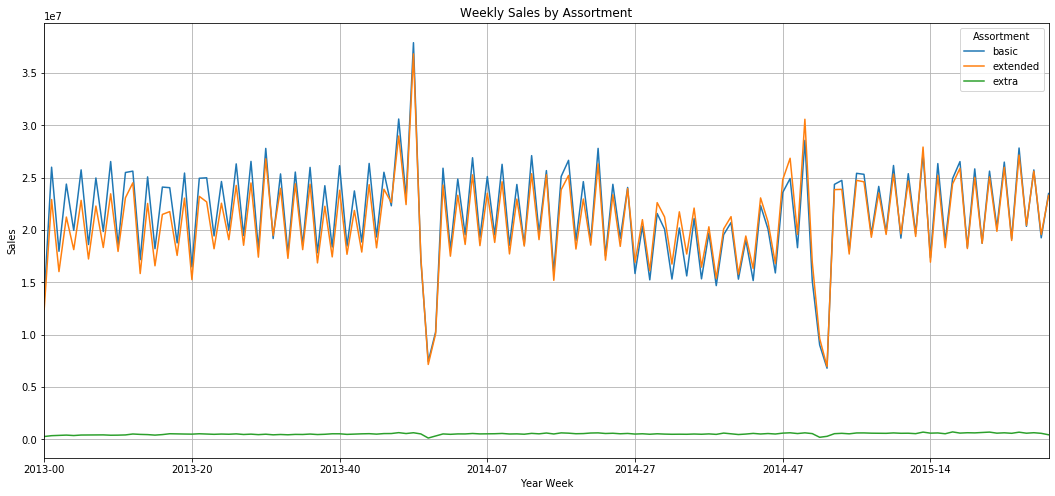

<Figure size 1296x576 with 0 Axes>

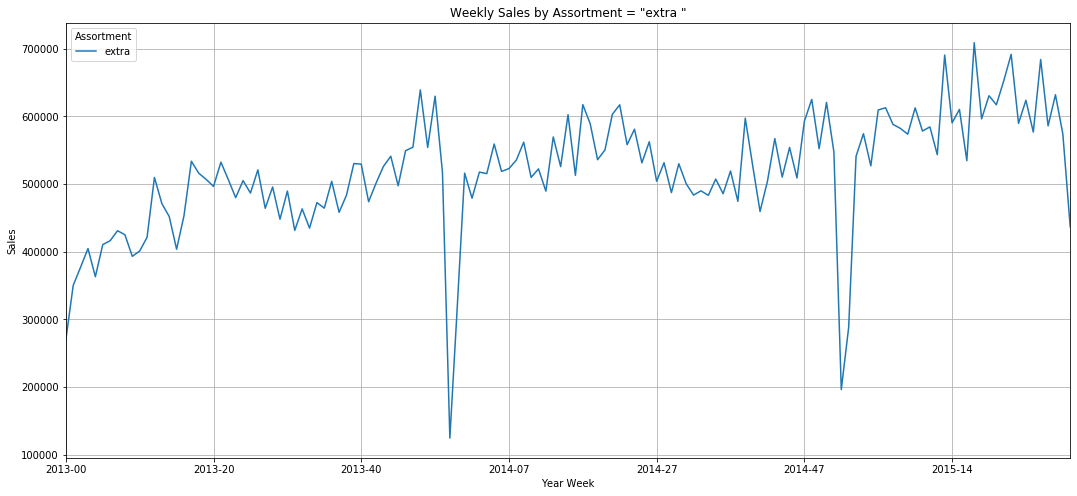

In [37]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(16, 12))
sns.barplot( x='assortment', y = 'sales', data = aux1 )

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
pivot_data = aux2.pivot(index='year_week', columns='assortment', values='sales')

# Ajustar o tamanho da figura do segundo gráfico
plt.figure(figsize=(18, 8))  # Largura 18, Altura 8
pivot_data.plot(figsize=(18, 8))  # Garantir que o gráfico seja grande o suficiente
plt.title('Weekly Sales by Assortment')
plt.xlabel('Year Week')
plt.ylabel('Sales')
plt.legend(title='Assortment')
plt.grid(True)
plt.show()

aux3 = aux2[aux2['assortment'] == 'extra']
pivot_data2 = aux3.pivot(index='year_week', columns='assortment', values='sales')

# Ajustar o tamanho da figura do segundo gráfico
plt.figure(figsize=(18, 8))  # Largura 18, Altura 8
pivot_data2.plot(figsize=(18, 8))  # Garantir que o gráfico seja grande o suficiente
plt.title('Weekly Sales by Assortment = "extra "')
plt.xlabel('Year Week')
plt.ylabel('Sales')
plt.legend(title='Assortment')
plt.grid(True)
plt.show()

In [38]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### H2. Lojas com competidores mais próximos deveriam vender menos.
**Falsa** lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

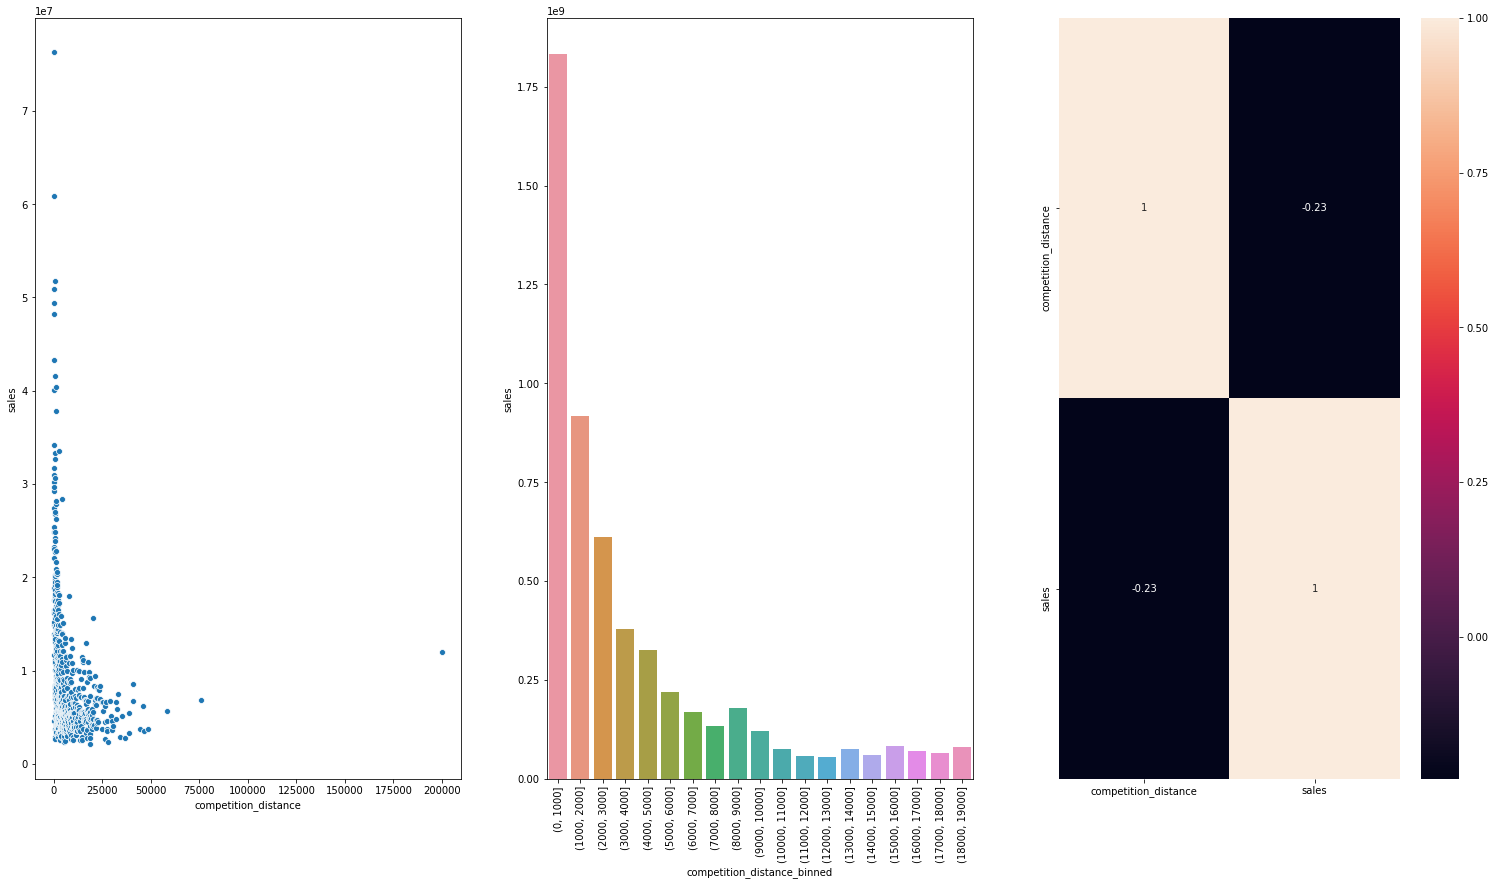

In [39]:

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(26, 14))
plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance' , y='sales', data = aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
#plt.figure(figsize=(26, 14))
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 )

plt.subplot( 1, 3, 3 )

sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

In [40]:
aux1.head()

,competition_distance,sales,competition_distance_binned
0,20.0,4579807,"(0, 1000]"
1,30.0,17552666,"(0, 1000]"
2,40.0,29261626,"(0, 1000]"
3,50.0,60835848,"(0, 1000]"
4,60.0,22088359,"(0, 1000]"


### H3. Lojas com competidores à mais tempo deveriam vender mais.
**Falsa** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS.

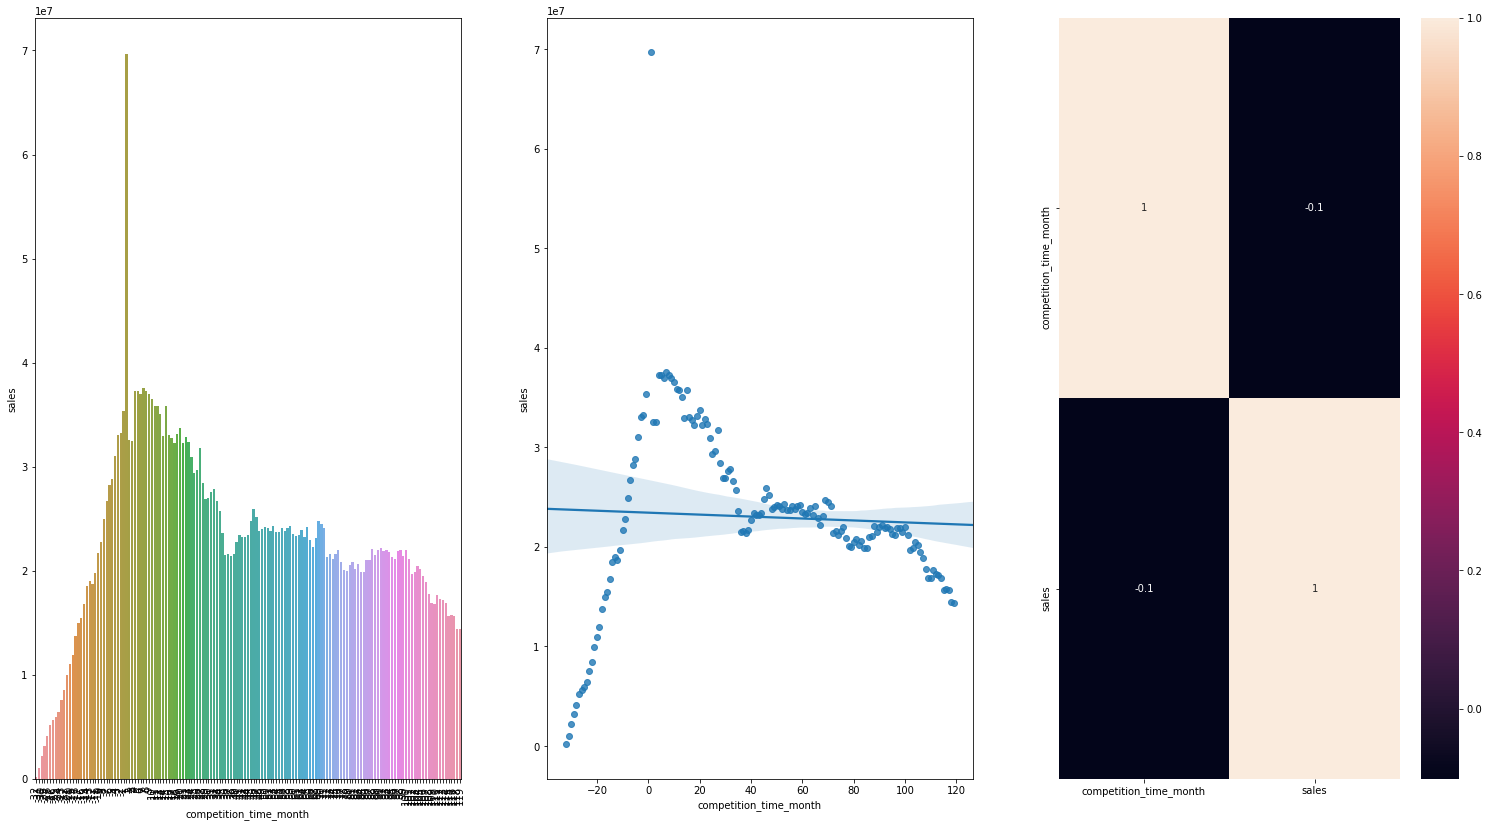

In [41]:
plt.figure(figsize=(26, 14))
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120  ) & ( aux1['competition_time_month'] != 0 )]

sns.barplot( x= 'competition_time_month', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x= 'competition_time_month', y = 'sales', data = aux2 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot= True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período da promoção

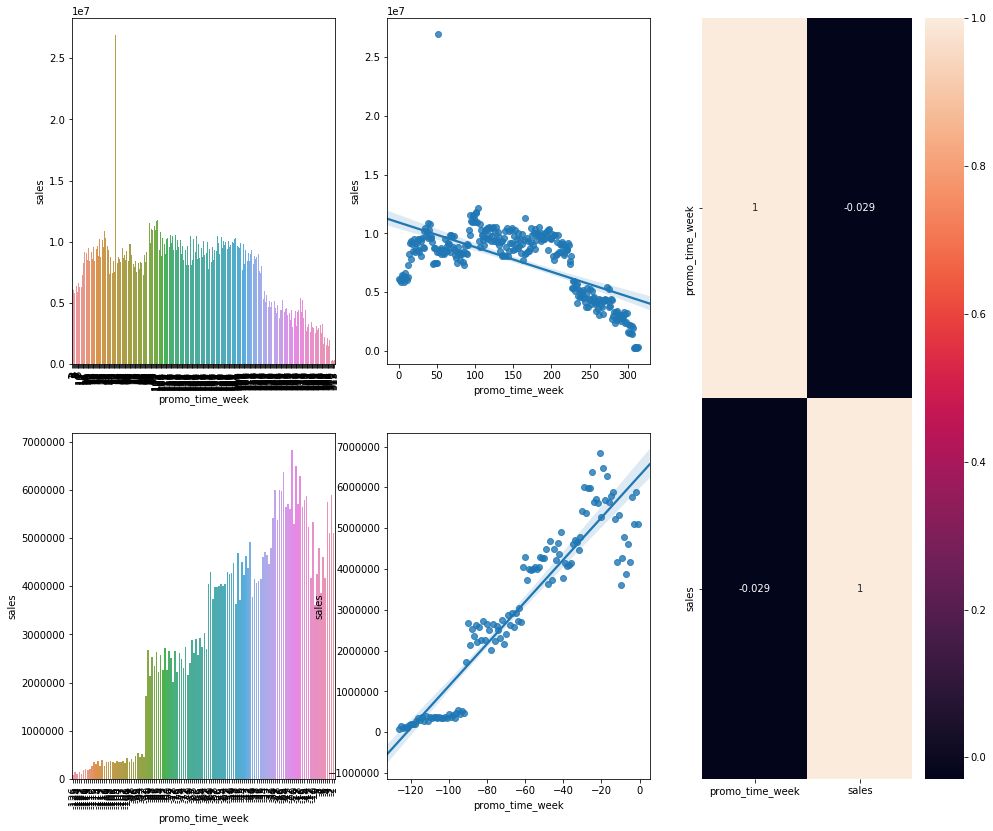

In [42]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2, 3 )

#sns.barplot(x = 'promo_time_week', y = 'sales', data= aux1);
plt.figure(figsize=(16, 14))
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data= aux2);
plt.xticks( rotation = 90)

plt.subplot( grid[0,1] )
sns.regplot(x = 'promo_time_week', y = 'sales', data= aux2);


plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data= aux3);
plt.xticks( rotation = 90)

plt.subplot( grid[1,1] )
sns.regplot(x = 'promo_time_week', y = 'sales', data= aux3);

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [43]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


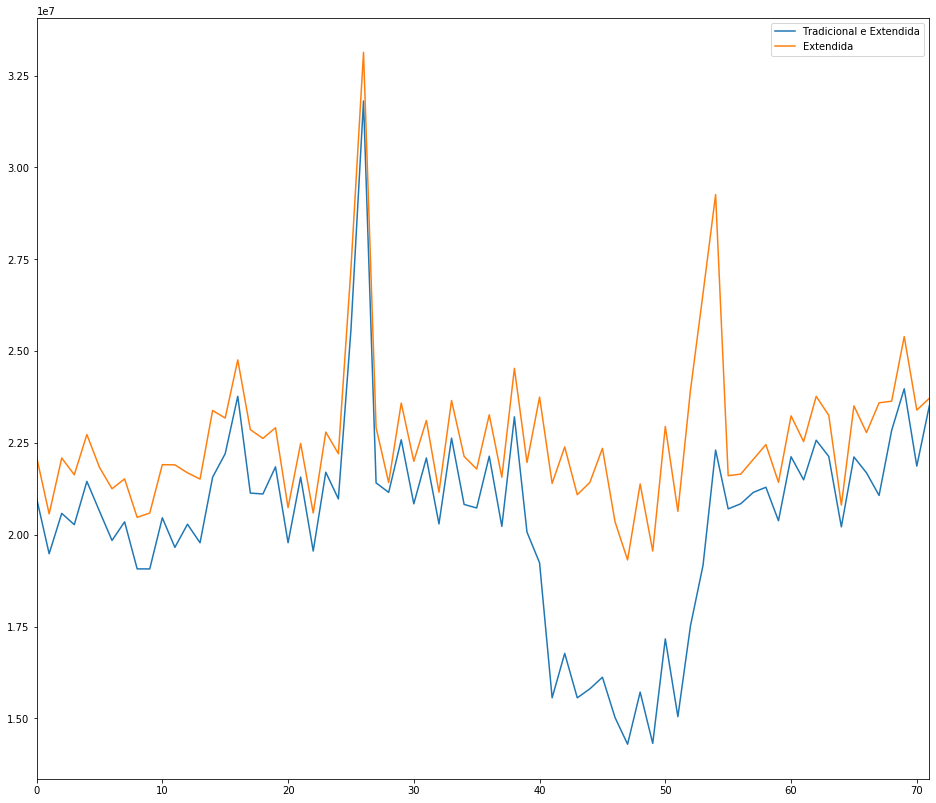

In [44]:

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot(figsize=(16, 14))

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot(ax = ax, figsize=(16, 14) )

ax.legend( labels = ['Tradicional e Extendida', 'Extendida'] )

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender menos.
**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

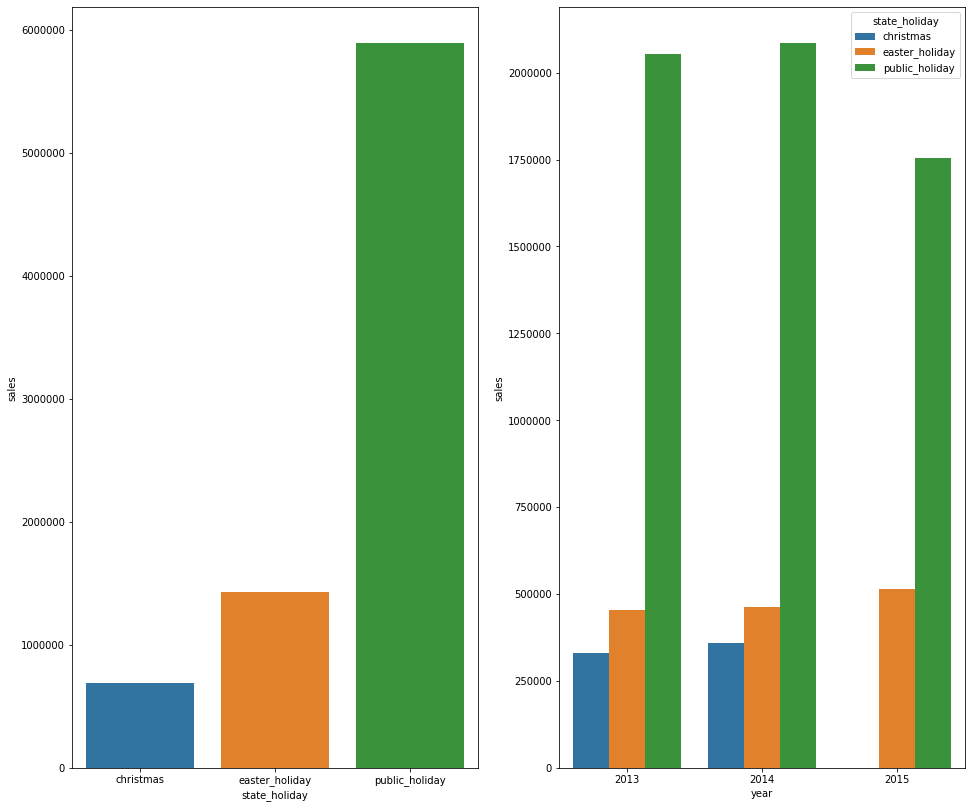

In [45]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()

plt.figure(figsize=(16, 14))
plt.subplot( 1, 2, 1 )
sns.barplot( x='state_holiday', y='sales', data = aux1 )

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue = 'state_holiday', data = aux2 )

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

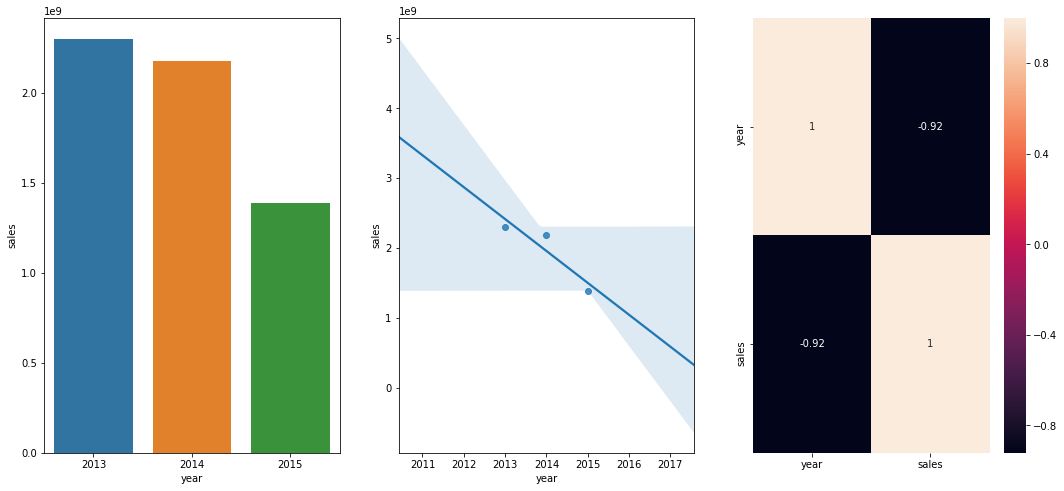

In [46]:
aux1 = df4[['year','sales']].groupby( 'year' ).sum().reset_index()
plt.figure(figsize=(18, 8))

plt.subplot( 1, 3, 1 )
sns.barplot( x = 'year', y= 'sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.regplot( x = 'year', y= 'sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

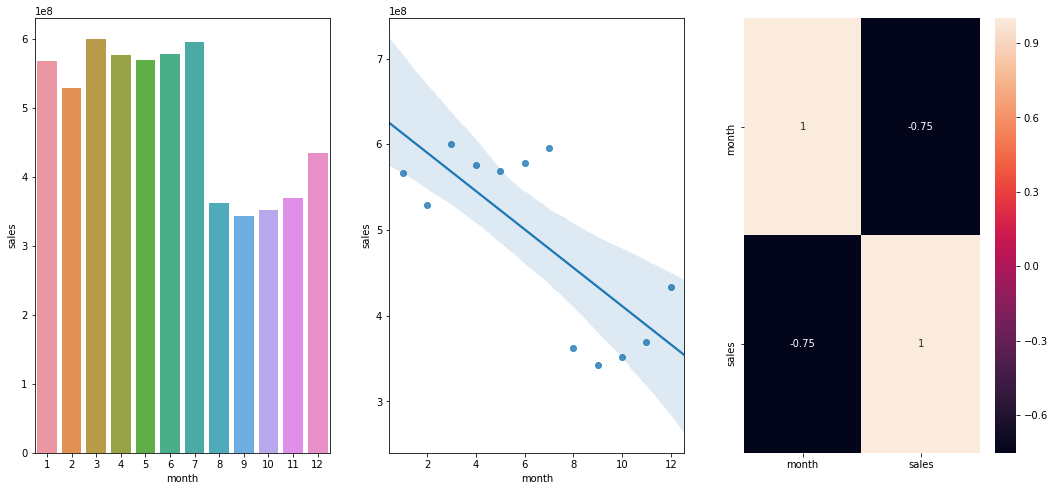

In [47]:
aux1 = df4[['month','sales']].groupby( 'month' ).sum().reset_index()
plt.figure(figsize=(18, 8))

plt.subplot( 1, 3, 1 )
sns.barplot( x = 'month', y= 'sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.regplot( x = 'month', y= 'sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

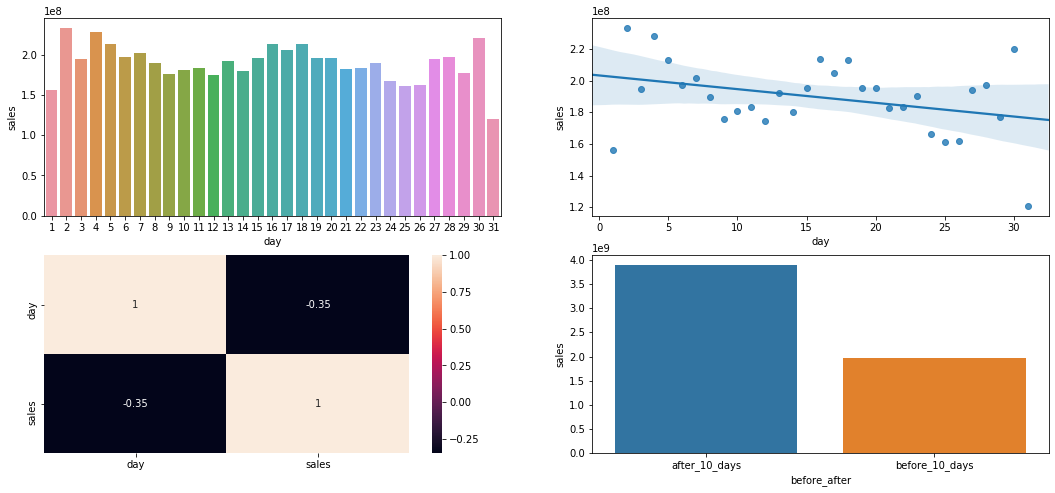

In [48]:
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()
plt.figure(figsize=(18, 8))

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'day', y= 'sales', data = aux1 )

plt.subplot( 2, 2, 2 )
sns.regplot( x = 'day', y= 'sales', data = aux1 )

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

plt.subplot( 2, 2, 4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <=10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x = 'before_after', y= 'sales', data = aux2 );

### **H11.** Lojas deveriam vender menos nos fins de semana.
**VERDADEIRA** Lojas vendem menos aos fins de semana.

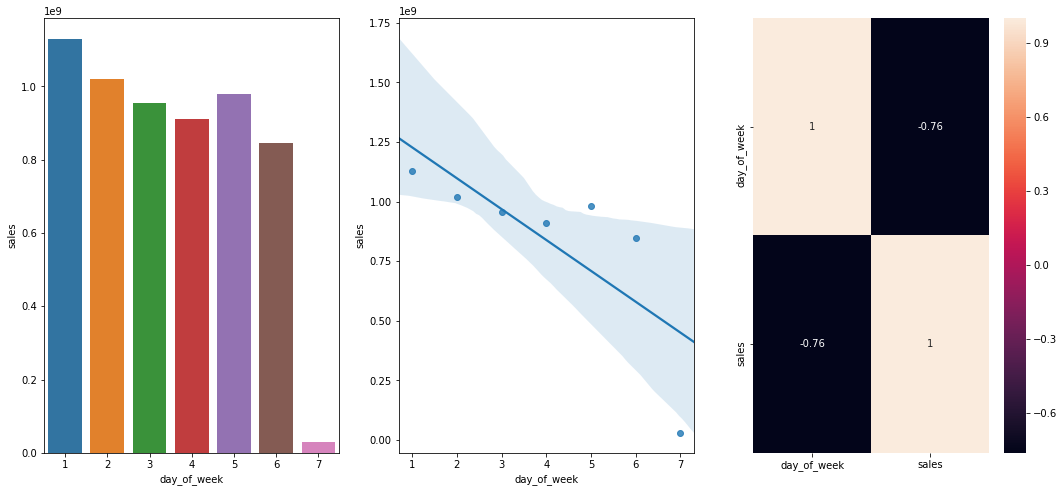

In [49]:
aux1 = df4[['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.figure(figsize=(18, 8))

plt.subplot( 1, 3, 1 )
sns.barplot( x = 'day_of_week', y= 'sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.regplot( x = 'day_of_week', y= 'sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H12.** Lojas deveriam vender menos nos feriados escolares.
**VERDADEIRA** Lojas vendem menos em feriados escolares.

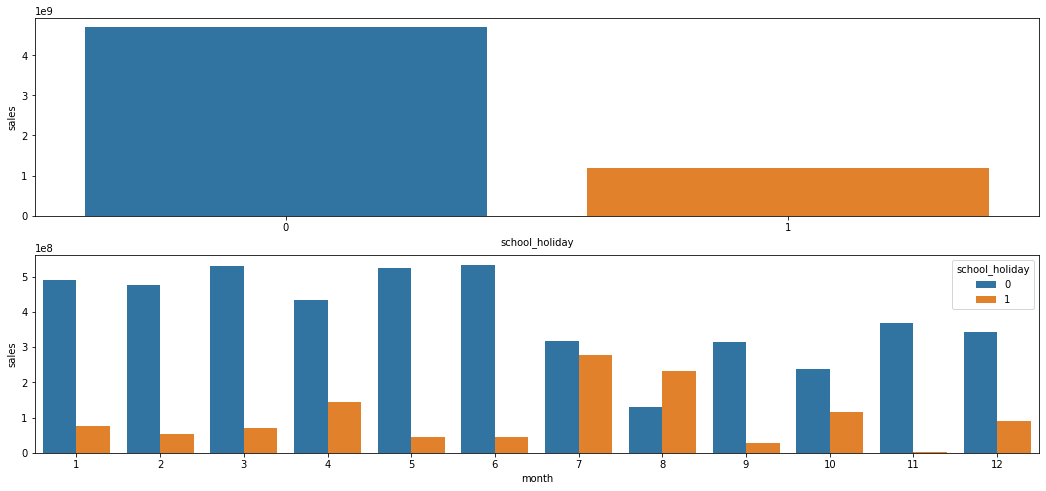

In [50]:
plt.figure(figsize = (18,8))
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data = aux1 );

plt.subplot(2, 1, 2)
aux2 = df4[['month','school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue = 'school_holiday', data = aux2 );

## 4.3 Análise multivariada

### 4.3.1. Numerical Attributes

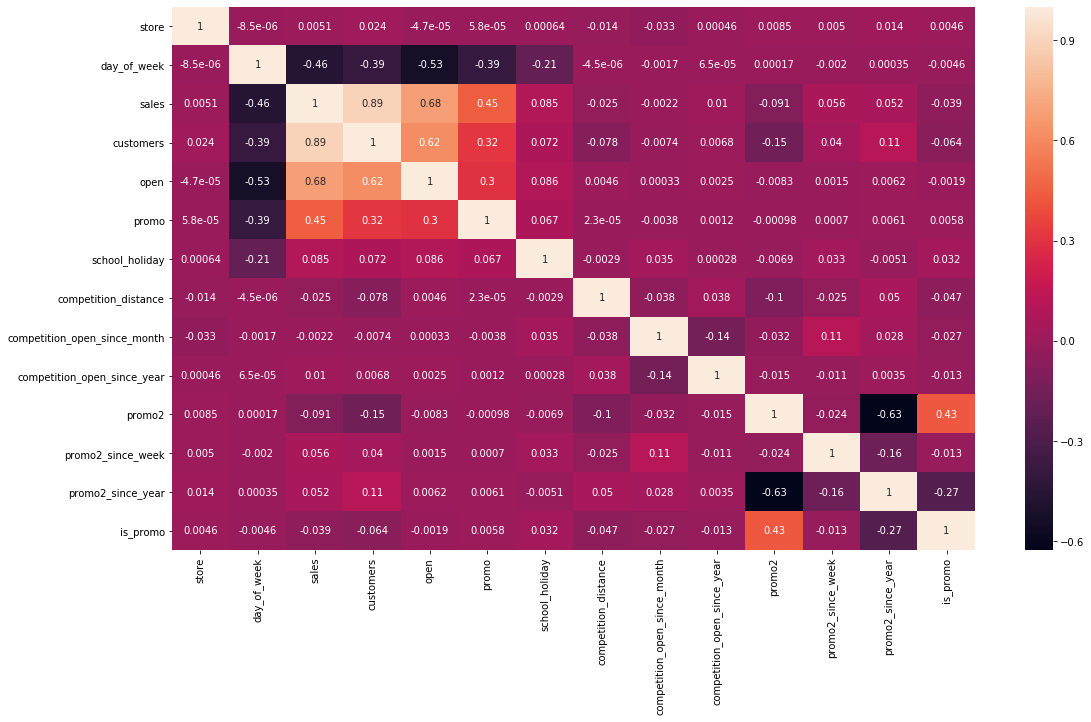

In [51]:
correlation = num_attributes.corr( method = 'pearson')
plt.figure( figsize = (18,10) )
sns.heatmap( correlation, annot = True )

### 4.3.1. Categorical Attributes

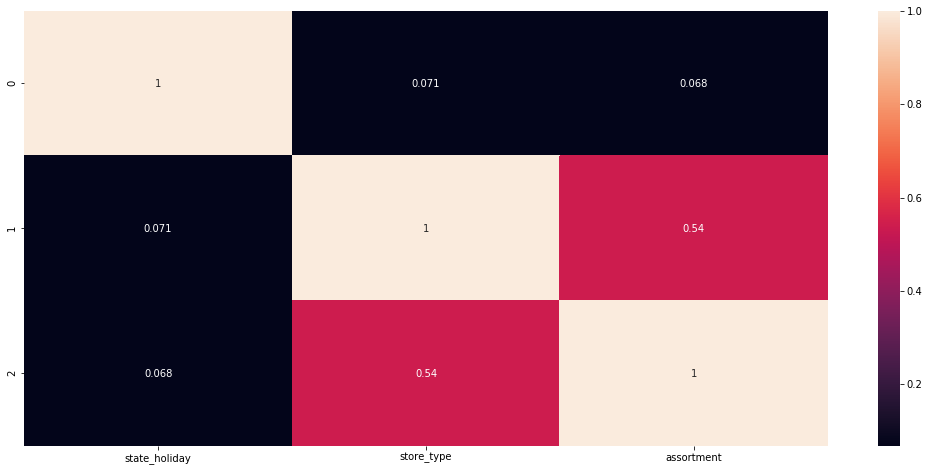

In [52]:
a = df4.select_dtypes( include='object' )

a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday':[a1,a2,a3],
               'store_type':[a4,a5,a6],
               'assortment':[a7,a8,a9]} )

d.set_index( d.columns )

plt.figure( figsize = (18,8) )
sns.heatmap( d, annot = True )

# 5.0. PASSO 05 - DATA PREPARATION

In [53]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [91]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/competition_distance_scaler.pkl', 'wb' ) )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/competition_time_month_scaler.pkl', 'wb' ) )

#promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/promo_time_week_scaler.pkl', 'wb' ) )

#year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/year_scaler.pkl', 'wb' ) )

## 5.3. Transformação

### 5.3.1. Encoding

In [55]:
#state_holiday - One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open('/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/store_type_scaler.pkl', 'wb') )

#assortment - Ordinal Encoding
assortment_dict = {'basic':1, 
                   'extra':2, 
                   'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable Transformation

In [57]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [58]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x *( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x *( 2. * np.pi/7 ) ) )

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x *( 2. * np.pi/12 ) ) )

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x *( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x *( 2. * np.pi/30 ) ) )

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x *( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x *( 2. * np.pi/52 ) ) )


In [59]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [60]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [61]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [62]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [63]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']


#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f"Training Min date {X_train['date'].min()}")
print(f"Training Max date {X_train['date'].max()}")
print(f"\nTest Min date {X_test['date'].min()}")
print(f"Test Max date {X_test['date'].max()}")

Training Min date 2013-01-01 00:00:00
Training Max date 2015-06-18 00:00:00

Test Min date 2015-06-19 00:00:00
Test Max date 2015-07-31 00:00:00


## 6.2. Boruta as Feature selector

In [64]:
#training and test dataset for boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

#define randon ForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

#define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [65]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [66]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos', 
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

#columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [67]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [68]:
aux1 = x_test.copy()
aux1['sales'] = y_test

#prediction
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns= {'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model_Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


In [69]:
baseline_result = pd.DataFrame( { 'Model_Name' : 'Average Mode',
                           'MAE' : 1354.800353,
                           'MAPE' :0.455051,
                           'RMSE' : 1835.135542}, index=[0] )
baseline_result

,Model_Name,MAE,MAPE,RMSE
0,Average Mode,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [70]:
#model 
lr = LinearRegression().fit( x_train, y_train )

In [69]:
#prediction
yhat_lr = lr.predict( x_test )

#performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model_Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


In [71]:
lr_result = pd.DataFrame( { 'Model_Name' : 'Linear Regression',
                           'MAE' : 1867.089774,
                           'MAPE' :0.292694,
                           'RMSE' : 2671.049215}, index=[0] )

### 7.2.1. Linear Regression Model - Cross Validation

In [72]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose = False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [73]:
#model 
lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train )

In [ ]:
#prediction
yhat_lrr = lrr.predict( x_test )

#performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

In [74]:
lrr_result = pd.DataFrame( { 'Model_Name' : 'Linear Regression - Lasso',
                           'MAE' :1891.704881,
                           'MAPE' : 0.289106,
                           'RMSE' : 2744.451737}, index=[0] )
lrr_result

,Model_Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [75]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose = False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [75]:
#model 
rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42 ).fit( x_train, y_train )

In [70]:

#prediction
yhat_rf = rf.predict( x_test )

#performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

KeyboardInterrupt: 

In [76]:
rf_result = pd.DataFrame( { 'Model_Name' : 'Random Forest Regressor',
                           'MAE' :678.296634,
                           'MAPE' : 0.099816,
                           'RMSE' : 1008.24895}, index=[0] )
rf_result

,Model_Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.296634,0.099816,1008.24895


### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose = True )
#rf_result_cv

In [77]:
rf_result_cv = pd.DataFrame({
                'Model Name': 'Random Forest Regressor',
                'MAE CV': '838.18 +/- 218.74',
                'MAPE CV': '0.12 +/- 0.02',
                'RMSE CV': '1256.87 +/- 319.67'
                   }, index=[0])
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67


## 7.5. XGBooster Regressor

In [75]:
#model 
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = 100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

In [76]:
# #prediction
# yhat_xgb = model_xgb.predict( x_test )

# #performance
# xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
# xgb_result

,Model_Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112293,0.122609,1250.952637


In [78]:
xgb_result = pd.DataFrame( { 'Model_Name' : 'XGBoost Regressor',
                           'MAE' :843.112293,
                           'MAPE' : 0.122609,
                           'RMSE' : 1250.952637}, index=[0] )
xgb_result

,Model_Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112293,0.122609,1250.952637


### 7.5. XGBooster Regressor - Cross Validation

In [ ]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True )
#xgb_result_cv

In [79]:
xgb_result_cv = pd.DataFrame({
                'Model Name': 'XGBoost Regressor',
                'MAE CV': '1030.28 +/- 167.19',
                'MAPE CV': '0.14 +/- 0.02',
                'RMSE CV': '1478.26 +/- 229.79'
                   }, index=[0])
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

### 7.6.1 Single Performance

In [80]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model_Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.296634,0.099816,1008.248950
0,XGBoost Regressor,843.112293,0.122609,1250.952637
0,Average Mode,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [81]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


# 8.0. PASSO 08 - HYPERPARAMETHER FINE TUNNING

## 8.1. Random Search

In [82]:
# param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
#          'eta':[0.01, 0.03],
#          'max_depth':[3, 5, 9],
#          'subsample':[0.1, 0.5, 0.7],
#          'colsample_bytee':[0.3, 0.7, 0.9],
#          'min_child_weight':[3, 8, 15]
#         }

# MAX_EVAL = 10

In [ ]:
# final_result = pd.DataFrame()
# for i in range( MAX_EVAL ):
#     #chose values for paramethers randomly
#     hp = {k: random.sample( v, 1 )[0] for k, v in param.items()}
#     print( hp )
#     #model 
#     model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
#                                   n_estimators = hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytee=hp['colsample_bytee'],
#                                   min_child_weight= hp['min_child_weight']) 

    

#     #performance
#     result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
#     final_result = pd.concat( [final_result, result] )
    
# final_result

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.9, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 8}


## 8.2. Final Model

In [80]:
# param_tuned = {
#          'n_estimators':3000,
#          'eta':0.03,
#          'max_depth': 5,
#          'subsample': 0.7,
#          'colsample_bytee': 0.7,
#          'min_child_weight': 3
#         }

In [83]:
# model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror',
#                                   n_estimators = param_tuned['n_estimators'],
#                                   eta=param_tuned['eta'],
#                                   max_depth=param_tuned['max_depth'],
#                                   subsample=param_tuned['subsample'],
#                                   colsample_bytee=param_tuned['colsample_bytee'],
#                                   min_child_weight= param_tuned['min_child_weight']).fit( x_train, y_train ) 

# #prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# #performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

In [84]:
# xgb_result_tuned

,Model_Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974997,0.097529,957.774225


In [87]:
pickle.dump( model_xgb_tuned, open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/model/model_rossman.pkl', 'wb' ) )

# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [82]:


# Carregar o modelo do arquivo .pkl
with open('/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/model/model_rossman.pkl', 'rb') as file:
    model_xgb_tuned = pickle.load(file)

# Testar o modelo carregado
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

#performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

In [83]:
df9 = X_test[ cols_selected_boruta_full ]

#rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [84]:
#somar as predições
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

#MAE MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0: 'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0: 'MAPE'} )

#merge

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how = 'inner', on='store' )
df92 =pd.merge( df91, df9_aux3, how = 'inner', on='store' )

#scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [85]:
df92.sort_values( 'MAPE', ascending = False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.085938,100714.981535,107351.190340,3318.104402,0.565828
908,909,238233.875000,230573.337254,245894.412746,7660.537746,0.520433
875,876,203030.156250,199110.952414,206949.360086,3919.203836,0.305099
721,722,353005.781250,351013.625119,354997.937381,1992.156131,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


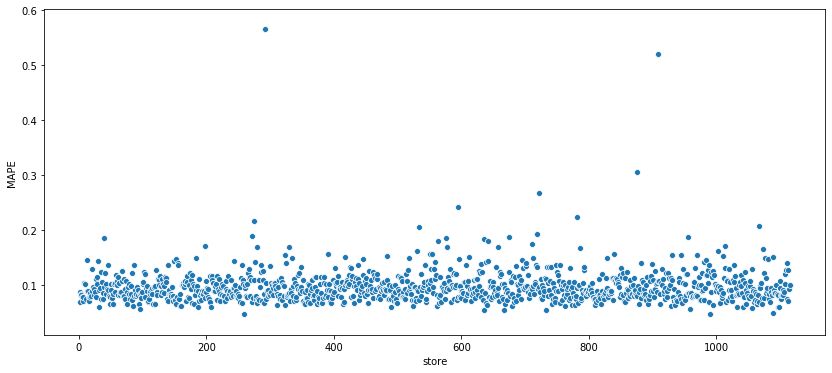

In [86]:
plt.figure( figsize = (14,6) )
sns.scatterplot( x='store', y='MAPE', data = df92 )

## 9.2. Total Performance

In [87]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename(  columns= {'Index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,index,Values
0,predictions,"R$285,860,497.84"
1,worst_scenario,"R$285,115,015.78"
2,best_scenario,"R$286,605,979.91"


## 9.1. Machine Learning Performance

In [88]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

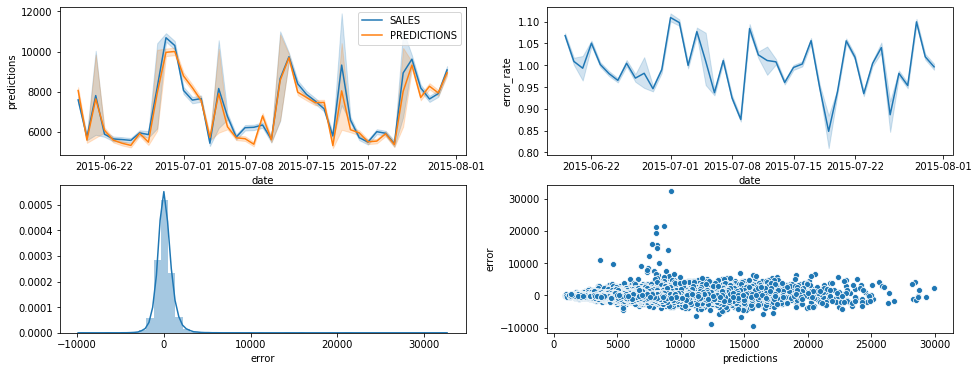

In [89]:
plt.figure( figsize = (16, 6))
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data = df9, label ='SALES' )
sns.lineplot( x='date', y='predictions', data = df9, label ='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data = df9 )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. - PASS0 10 - DEPLOY MODEL TO PRODUCTION

## 10.1. Rossmann Class

In [16]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.competiton_distance_scaler    = pickle.load( open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/encoding_competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/encoding_promo_time_week_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/encoding_competition_time_month_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/parameter/store_type_scaler.pkl', 'rb') )
        state = 1
    
    def data_cleaning( self, df1 ):
        

        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )

        #rename
        df1.columns = cols_new

        
        ## 1.3. Data Types

        df1['date'] = pd.to_datetime( df1['date'] )


        ## 1.5. Fillout NA

        #competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply ( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

        #promo2_since_week    
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)


        #promo2_since_year  
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

        #promo_interval 
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna( 0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0 , axis = 1)


        ## 1.6. Chage Data Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
    
    def feature_engineering( self, df2 ):
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days).astype( int )

        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else  'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


        df2.head().T

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Seleção de colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis = 1 )
        
        return df2
    
    def data_preparation( self, df5 ):
    

        ## 5.2. Rescaling
        #Competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )


        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        

        #year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )



        ### 5.3.1. Encoding
        #state_holiday - One hot encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        #store_type - Label encoding
        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        
        #assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 
                           'extra':2, 
                           'extended':3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )



        ### 5.3.3. Nature Transformation
        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x *( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x *( 2. * np.pi/7 ) ) )

        #month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x *( 2. * np.pi/12 ) ) )

        #day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x *( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x *( 2. * np.pi/30 ) ) )

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x *( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x *( 2. * np.pi/52 ) ) )

        
        cols_selected = [
             'store',
             'promo',
             'store_type',
             'assortment',
             'competition_distance',
             'competition_open_since_month',
             'competition_open_since_year',
             'promo2',
             'promo2_since_week',
             'promo2_since_year',
             'competition_time_month',
             'promo_time_week',
             'day_of_week_sin',
             'day_of_week_cos',
             'month_sin',
             'month_cos', 
             'day_sin',
             'day_cos',
             'week_of_year_sin',
             'week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data ):
        #predictions
        pred = model.predict( test_data )
        
        #join pred into  the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient = 'records', date_format = 'iso' )

## 10.2. API Handler

In [17]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load( open('/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/model/model_rossmann.pkl', 'rb' ) )

#initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:  #there is data
        if isinstance( test_json, dict ): #unique example
            test_raw = pd.Dataframe( test_json, index= [0] )
        
        else:   #Multiple examples
            test_raw = pd.Dataframe( test_json, columns=test_json[0].keys() )
            
        #instantiate Rossmann Class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        #feature engineering
        df1 = pipeline.feature_engineering( df1 )
        
        #data preparation
        df3 = pipeline.data_preparation( df2 )
        
        #prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
            
    else:
        return Response( '{}', status = 200, mimetype = 'application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [11]:
import requests

In [4]:
#loading test dataset
df10 = pd.read_csv( '/mnt/c/Users/Eduardo_Alencar/Documents/repos/ds_producao/ds_em_producao-main/data/test.csv' )

In [39]:
#merge  test dataset + store
df_test = pd.merge( df10, df_store_raw, how = 'left', on= 'Store' )

#choose store for prediction
df_test = df_test[df_test['Store'].isin( [24, 12, 22] )]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis = 1 )

In [40]:
#Convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [41]:
#API call
url = 'http://0.0.0.0:5000/rossmann/predict'
header = { 'Content-type' : 'application/json' }
data = data

r = requests.post( url, data = data, headers = header )
print( f'Status Code {r.status_code}' )

Status Code 200


In [42]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [32]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4567.860352
1,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4681.688477
2,22,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,15,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5427.026367
3,22,1,2015-09-14T00:00:00.000Z,1.0,1,regular_day,1,a,basic,1040.0,...,2015,9,14,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6097.774902
4,22,6,2015-09-12T00:00:00.000Z,1.0,0,regular_day,0,a,basic,1040.0,...,2015,9,12,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,2718.891113


In [43]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number: {} will sell  R${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i,'prediction'] ) )
    d2.loc[i, 'store']
    d2.loc[i, 'prediction']

Store Number: 12 will sell  R$248,715.94 in the next 6 weeks
Store Number: 22 will sell  R$147,607.40 in the next 6 weeks
Store Number: 24 will sell  R$263,343.42 in the next 6 weeks


,store,prediction
0,22,154065.041138
